In [ ]:
!pip install boto3
import boto3
import os
import requests
import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
dynamo_client  =  boto3.resource(service_name = 'dynamodb',region_name = 'us-east-1',
              aws_access_key_id = '******************',
              aws_secret_access_key = '*************************')

In [ ]:
dynamo_client.get_available_subresources()

['Table']

In [ ]:
data_table = dynamo_client.Table('TemperatureHumidity')
data_table.table_status

'ACTIVE'

In [ ]:
data_table.scan()['Items']

[{'humidity': Decimal('19.29999924'),
  'temperature': Decimal('1.100000024'),
  'timestamp': '1970-01-01 00:00:04'},
 {'humidity': Decimal('21'),
  'temperature': Decimal('1.700000048'),
  'timestamp': '1970-01-01 00:10:42'},
 {'humidity': Decimal('19.79999924'),
  'temperature': Decimal('1.600000024'),
  'timestamp': '1970-01-01 00:04:29'},
 {'humidity': Decimal('21.10000038'),
  'temperature': Decimal('1.700000048'),
  'timestamp': '1970-01-01 00:11:05'},
 {'humidity': Decimal('21'),
  'temperature': Decimal('1.700000048'),
  'timestamp': '1970-01-01 00:10:26'},
 {'humidity': Decimal('19.60000038'),
  'temperature': Decimal('1.5'),
  'timestamp': '1970-01-01 00:03:09'},
 {'humidity': Decimal('20.5'),
  'temperature': Decimal('1.600000024'),
  'timestamp': '1970-01-01 00:07:10'},
 {'humidity': Decimal('19'),
  'temperature': Decimal('1.399999976'),
  'timestamp': '1970-01-01 00:01:09'},
 {'humidity': Decimal('21.5'),
  'temperature': Decimal('1.600000024'),
  'timestamp': '1970-01-01

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [ ]:
table = dynamo_client.Table('TemperatureHumidity')
response = table.scan(
    ExpressionAttributeNames={'#ts': 'timestamp'},
    ProjectionExpression='#ts, temperature, humidity'
)

In [ ]:

from datetime import datetime, timedelta
from decimal import Decimal
# Create a Pandas DataFrame from the response
data_list = response['Items']
data_df = pd.DataFrame(data_list)

# Convert timestamp to datetime and set it as the index
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
data_df.set_index('timestamp', inplace=True)

In [ ]:
data_df.dtypes

humidity       object
temperature    object
dtype: object

In [ ]:
data_df['humidity'] = data_df['humidity'].astype(float)
data_df['temperature'] = data_df['temperature'].astype(float)

In [ ]:
ad_fuller_result_1 = adfuller(data_df['humidity'])

print('realgdp')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(data_df['temperature'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realgdp
ADF Statistic: -4.78217436171281
p-value: 5.88209888070204e-05

---------------------

realcons
ADF Statistic: -4.474921653649168
p-value: 0.0002182077535611803


In [ ]:
print('does humidity causes temperature?\n')
print('------------------')
granger_1 = grangercausalitytests(data_df[['temperature', 'humidity']], 4)

print('\does temperature causes humidity?\n')
print('------------------')
granger_2 = grangercausalitytests(data_df[['humidity', 'temperature']], 4)

does humidity causes temperature?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0945  , p=0.7586  , df_denom=856, df_num=1
ssr based chi2 test:   chi2=0.0948  , p=0.7581  , df=1
likelihood ratio test: chi2=0.0948  , p=0.7581  , df=1
parameter F test:         F=0.0945  , p=0.7586  , df_denom=856, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.9183  , p=0.0004  , df_denom=853, df_num=2
ssr based chi2 test:   chi2=15.9295 , p=0.0003  , df=2
likelihood ratio test: chi2=15.7834 , p=0.0004  , df=2
parameter F test:         F=7.9183  , p=0.0004  , df_denom=853, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1380  , p=0.0004  , df_denom=850, df_num=3
ssr based chi2 test:   chi2=18.5655 , p=0.0003  , df=3
likelihood ratio test: chi2=18.3673 , p=0.0004  , df=3
parameter F test:         F=6.1380  , p=0.0004  , df_denom=850, df_num=3

Granger Causality
number of lags (no ze

In [ ]:
print(data_df.shape)

(860, 2)


In [ ]:
train_df=data_df[:500]
test_df=data_df[500:]

In [ ]:
print(train_df.shape)

(500, 2)


In [ ]:
print(test_df.shape)

(360, 2)


In [ ]:
model = VAR(train_df.diff()[1:])

In [ ]:
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.844      -3.826     0.02141      -3.837
1       -4.408      -4.356     0.01217      -4.388
2       -4.625      -4.538    0.009802      -4.591
3       -4.730      -4.608    0.008823      -4.682
4       -4.794      -4.637    0.008280      -4.732
5       -4.841      -4.650    0.007897      -4.766
6       -4.895     -4.668*    0.007488      -4.806
7       -4.925      -4.664    0.007265      -4.822
8       -4.937      -4.641    0.007177      -4.821
9       -4.957      -4.626    0.007033      -4.827
10      -4.991      -4.625    0.006798      -4.847
11      -4.984      -4.583    0.006850      -4.826
12      -5.034      -4.598    0.006516     -4.862*
13      -5.027      -4.557    0.006560      -4.842
14      -5.053      -4.548    0.006391      -4.855
15      -5.073      -4.533    0.006267      -4.861
16      -5.073      -4.499    0

In [ ]:
var_model = VARMAX(train_df, order=(17,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                                Statespace Model Results                               
Dep. Variable:     ['humidity', 'temperature']   No. Observations:                  500
Model:                                 VAR(17)   Log Likelihood                 -71.456
                                   + intercept   AIC                            288.912
Date:                         Fri, 11 Aug 2023   BIC                            596.579
Time:                                 06:47:38   HQIC                           409.640
Sample:                                      0                                         
                                         - 500                                         
Covariance Type:                           opg                                         
Ljung-Box (L1) (Q):             0.01, 0.00   Jarque-Bera (JB):          26.51, 7.88
Prob(Q):                        0.91, 0.95   Prob(JB):                   0.00, 0.02
Heteroskedasticity (H):         0.95, 1.

In [ ]:
n_forecast = 10
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)

predictions=predict.predicted_mean

In [ ]:
predictions.columns=['humidity_predicted','temperature_predicted']
predictions

,humidity_predicted,temperature_predicted
500,20.027438,1.557059
501,20.511732,1.561165
502,20.317370,1.569791
503,20.067814,1.532254
504,20.256255,1.570967
505,20.432544,1.589733
506,20.364264,1.550529
507,20.354685,1.559941
508,20.143878,1.586400
509,20.335343,1.575106


In [ ]:
test_vs_pred=pd.concat([test_df[0:10],predictions],axis=1)

<Axes: >

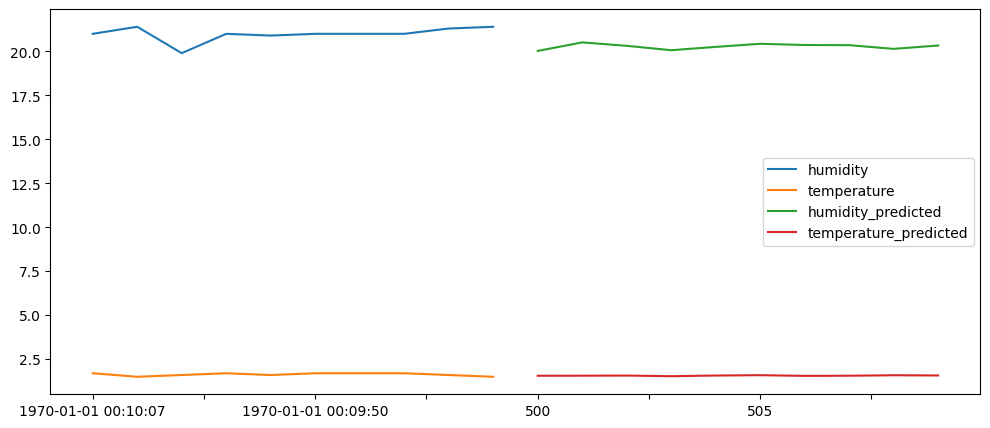

In [ ]:
test_vs_pred.plot(figsize=(12,5))

In [ ]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_ulc=math.sqrt(mean_squared_error(predictions['humidity_predicted'],test_df['humidity'][0:10]))
print('Mean value of Humidity is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['humidity']),rmse_ulc))

rmse_rgnp=math.sqrt(mean_squared_error(predictions['temperature_predicted'],test_df['temperature'][0:10]))
print('Mean value of Temperature is : {}. Root Mean Squared Error is :{}'.format(mean(test_df['temperature']),rmse_rgnp))

Mean value of Humidity is : 21.030277771444446. Root Mean Squared Error is :0.8249350945790548
Mean value of Temperature is : 1.9936111299111112. Root Mean Squared Error is :0.10677554929456382
